In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import foolbox

from wideresnet import WideResNet

## Generating adversarial examples for CIFAR-10, CIFAR-100, and TinyImagenet
- [x]  get cifar-10 - Done
- [x]  get cifar-100
- [ ]  ~get tiny-imagenet~, not needed, Prantik got ImageNet to work

## get pretrained pytorch models for each dataset
- [x] got them all

## generate adversarial examples
- [ ] FGSM
    - [x] MNIST
    - [ ] CIFAR10, a derivation of w32-10 wide, based on https://github.com/MadryLab/cifar10_challenge
    - [ ] CIFAR100, a derivation of w32-10 wide, based on https://github.com/MadryLab/cifar10_challenge
    - [ ] ~ImageNet~, Prantik got these

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))

trainset = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset_cifar100 = torchvision.datasets.CIFAR100(root='/data', train=True,download=True, transform=transform)
trainloader_cifar100 = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

testset_cifar100 = torchvision.datasets.CIFAR100(root='/data', train=False,download=True, transform=transform)
testloader_cifar100 = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [25]:
model = WideResNet(28, 100, 10)
# checkpoint = torch.load("/home/georgi/WideResNet-pytorch/runs/WideResNet-28-10/model_best.pth.tar")
checkpoint = torch.load("/home/georgi/WideResNet-pytorch/runs/WideResNet-28-10-cifar100/model_best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print('', end='')

In [10]:
fmodel = foolbox.models.PyTorchModel(model, bounds=(0,1), num_classes=100, preprocessing=(mean, std))

In [15]:
image, label = testset_cifar100[0]

In [12]:
image.numpy().shape

(3, 32, 32)

In [13]:
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image.numpy(), label)

(torch.Size([3, 32, 32]), 6)
predicted class 6
(3, 32, 32)
adversarial class 3


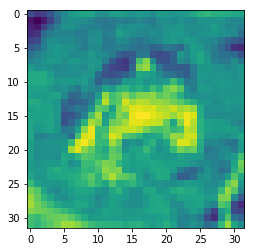

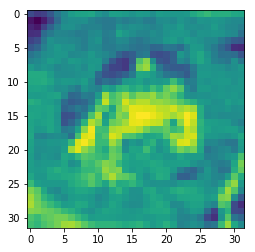

In [14]:
print((image.shape, label))
print('predicted class', np.argmax(fmodel.forward(np.expand_dims(image, 0))))
plt.figure()
plt.imshow(image[0,:,:])
adversarial = attack(image.numpy(), label, epsilons=[0.13]); 
adversarial = attack(image.numpy(), label); 
print(adversarial.shape)
print('adversarial class', np.argmax(fmodel.forward(np.expand_dims(adversarial, 0))))
plt.figure()
plt.imshow(adversarial[0,:,:])

In [26]:
# Accuracy counter
correct = 0
classifier_failed = 0
adversary_succeeded = 0
adversary_failed = 0
adv_examples = []
epsilon = 0.5
# attack = foolbox.attacks.GradientAttack(fmodel)
attack = foolbox.attacks.FGSM(fmodel)
attack_name = "fgsm"
attack_image_folder = "./cifar100/" + attack_name + "/"
!mkdir -p $attack_image_folder


# Loop over all examples in test set
for i in tqdm.tqdm_notebook(range(len(testset_cifar100))):

    # Send the data and label to the device
    image, target = testset_cifar100[i]

    # Forward pass the data through the model
    output = fmodel.forward(np.expand_dims(image, 0))
    init_pred = np.argmax(output) # get the index of the max log-probability

    # If the initial prediction is wrong, dont bother attacking, just move on
    if init_pred != target:
        classifier_failed += 1
        continue

    # Call FGSM Attack
    adversarial = attack(image.numpy(), label)

    if adversarial is None:
        adversary_failed += 1
        continue
    
    # Re-classify the perturbed image
    adv_output = fmodel.forward(np.expand_dims(adversarial, 0))
    perturbed_pred = np.argmax(adv_output)

    # Check for success
    if perturbed_pred == target:
        correct += 1
    else:
        adversary_succeeded += 1
        output_image = (adversarial[0,:,:] * 255).astype(np.uint8)
        imageio.imsave(attack_image_folder + attack_name + "_" + str(i) + ".png", output_image)
        with open(attack_image_folder + attack_name + "_" + str(i) + ".txt", "w") as file:
            file.write(str(perturbed_pred))

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:133: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [27]:
# Calculate final accuracy for this epsilon
final_acc = correct/float(len(testset))
print("Test Accuracy = {} / {} = {}".format(correct, len(testset_cifar100), final_acc))

Test Accuracy = 76 / 10000 = 0.0076
